In [1]:
import os
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np


In [3]:
arquivos = os.listdir()
arquivos=['artigo1_openAlex.csv',
 'artigo01_ResearchRabbit.csv',
 'artigo01_extracaoManual.csv',
 'Artigo01_Litmaps.csv',
 'artigo1_semantic_.csv',]

In [4]:
dados = {}
for nome in arquivos:
    if nome.endswith('.csv'):
            df = pd.read_csv(nome)
            dados[nome] = df
            #print(f"\nArquivo CSV lido: {nome}")
            #display(df.head())



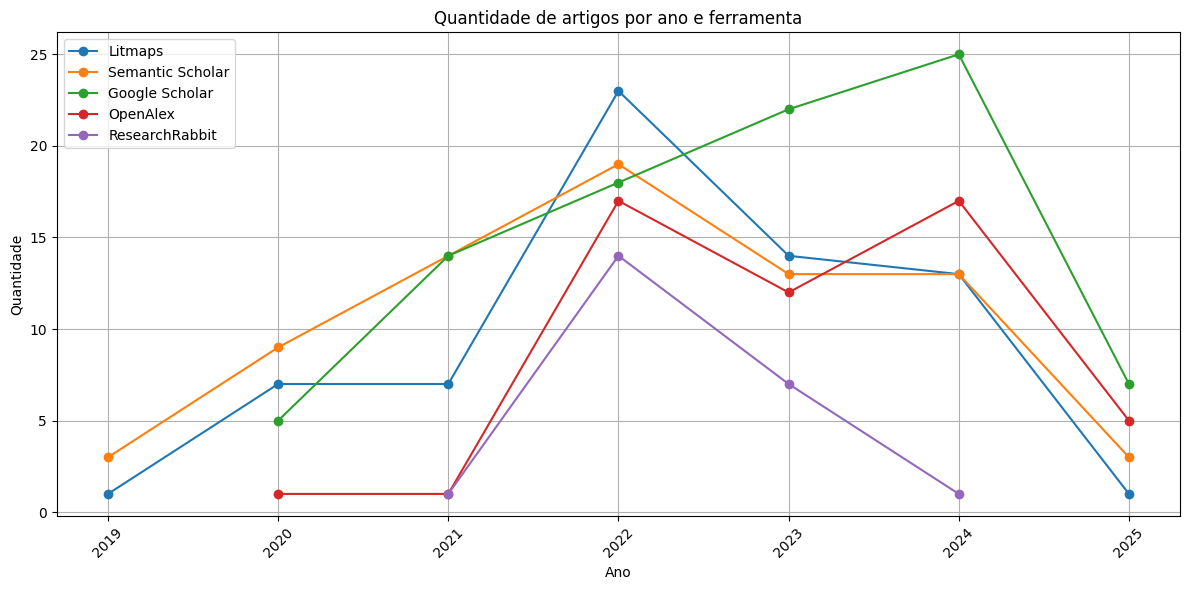

In [6]:
df_list = []
for nome_arquivo, df in dados.items():
    if df is None or not isinstance(df, pd.DataFrame):
        continue
    if "ResearchRabbit" in nome_arquivo:
        ferramenta = "ResearchRabbit"
    elif "litmaps" in nome_arquivo.lower():
        ferramenta = "Litmaps"
    elif "openalex" in nome_arquivo.lower():
        ferramenta = "OpenAlex"
    elif "semantic" in nome_arquivo.lower():
        ferramenta = "Semantic Scholar"
    else:
        ferramenta = "Google Scholar"

    df = df.copy()
    df['ferramenta'] = ferramenta

    # Normaliza o nome das colunas para facilitar (caso tenha diferenças)
    df.columns = [col.lower() for col in df.columns]

    ano_col = None
    for col in df.columns:
        if 'ano' in col or 'year' in col:
            ano_col = col
            break

    if ano_col:
        df = df[[ano_col, 'ferramenta']].rename(columns={ano_col: 'ano'})
        df = df[df['ano'].notnull()]
        df['ano'] = df['ano'].astype(str).str.extract(r'(\d{4})')  # extrai o ano de forma segura
        df_list.append(df)
    else:
        print(f"Nenhuma coluna de ano encontrada no arquivo: {nome_arquivo}")

df_todos = pd.concat(df_list, ignore_index=True)
df_todos = df_todos.dropna()

# Agrupa os dados
df_grouped = df_todos.groupby(['ano', 'ferramenta']).size().reset_index(name='quantidade')

# Plota o gráfico
plt.figure(figsize=(12,6))
for ferramenta in df_grouped['ferramenta'].unique():
    df_sub = df_grouped[df_grouped['ferramenta'] == ferramenta]
    plt.plot(df_sub['ano'], df_sub['quantidade'], marker='o', label=ferramenta)

plt.title('Quantidade de artigos por ano e ferramenta')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


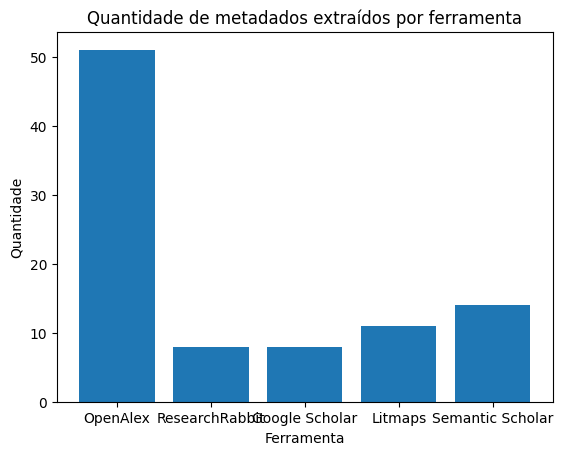

In [7]:
#quantidade de metadados por ferramenta
#import matplotlib.pyplot as plt

cobertura = {}

for nome_arquivo, df in dados.items():
    if df is None or not isinstance(df, pd.DataFrame):
        continue
    if "ResearchRabbit" in nome_arquivo:
        ferramenta = "ResearchRabbit"
    elif "litmaps" in nome_arquivo.lower():
        ferramenta = "Litmaps"
    elif "openalex" in nome_arquivo.lower():
        ferramenta = "OpenAlex"
    elif "semantic" in nome_arquivo.lower():
        ferramenta = "Semantic Scholar"
    else:
        ferramenta = "Google Scholar"

    cobertura[ferramenta] = cobertura.get(ferramenta, set()) | set(df.columns)

# Transforma em quantidade
cobertura_qtd = {f: len(cols) for f, cols in cobertura.items()}

# Plot
plt.bar(cobertura_qtd.keys(), cobertura_qtd.values())
plt.title("Quantidade de metadados extraídos por ferramenta")
plt.ylabel("Quantidade")
plt.xlabel("Ferramenta")
plt.show()


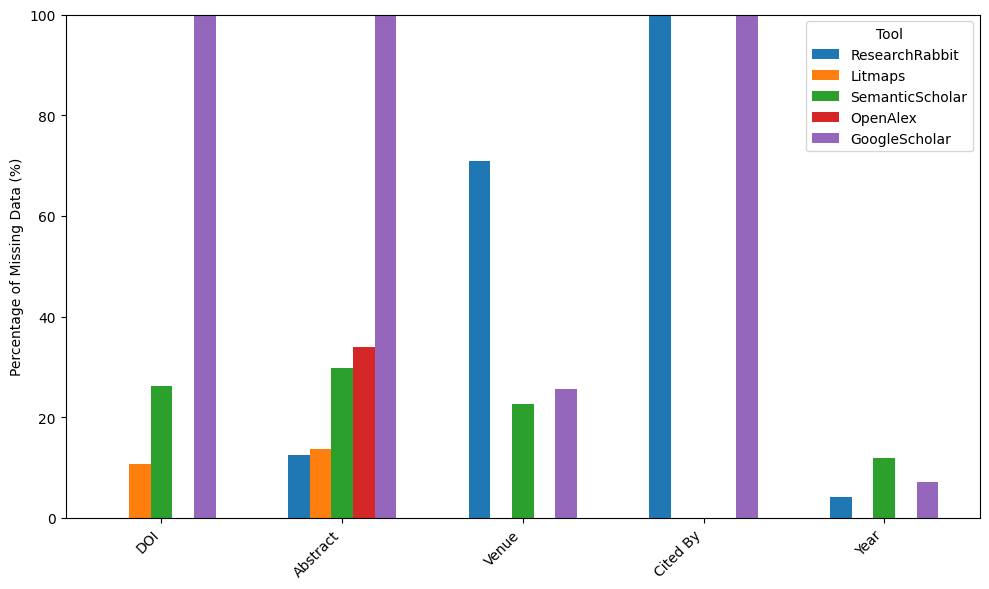

In [9]:
# Função para padronizar valores nulos incluindo strings indicativas de ausência
def marcar_nulos(serie):
    strings_missing = ['(missing doi)', '(missing abstract)', '(missing)', '(none)', 'na', 'n/a', 'nan', '']
    serie = serie.astype(str).str.lower()
    serie = serie.replace(strings_missing, pd.NA)
    return serie

# Metadados unificados
metadados_unificados = ['DOI', 'Abstract','Venue','Cited By','Year']

# Dicionário com possíveis colunas para cada metadado e ferramenta
colunas_por_metadado_ferramenta = {
    'Abstract': {
        'ResearchRabbit': ['abstract'],
        'Litmaps': ['abstract'],
        'SemanticScholar': ['abstract'],
        'OpenAlex': ['abstract_inverted_index'],
        'GoogleScholar': ['abstract'],
    },
    'DOI': {
        'ResearchRabbit': ['doi'],
        'Litmaps': ['doi'],
        'SemanticScholar': ['doi'],
        'OpenAlex': ['doi'],
        'GoogleScholar': ['doi'],
    },
    'Year': {
        'ResearchRabbit': ['year'],
        'Litmaps': ['year'],
        'SemanticScholar': ['year'],
        'OpenAlex': ['publication_year', 'year'],
        'GoogleScholar': ['year'],
    },
    'Venue': {
        'ResearchRabbit': ['journal'],
        'Litmaps': ['journal'],
        'SemanticScholar': ['venue'],
        'OpenAlex': ['journal', 'publication','primary_location'],
        'GoogleScholar': ['publication', 'journal'],
    },
    'Cited By': {
        'SemanticScholar': ['cited_by'],
        'OpenAlex': ['cited_by_count'],
        'Litmaps': ['cited_by'],
        'ResearchRabbit': [],
        'GoogleScholar': [],
    }
}

lista_percentuais = []

for nome_arquivo, df in dados.items():
    if df is None or not isinstance(df, pd.DataFrame):
        continue

    # Identifica ferramenta
    if "ResearchRabbit" in nome_arquivo:
        ferramenta = "ResearchRabbit"
    elif "litmaps" in nome_arquivo.lower():
        ferramenta = "Litmaps"
    elif "manual" in nome_arquivo.lower():
        ferramenta = "GoogleScholar"
    elif "openalex" in nome_arquivo.lower():
        ferramenta = "OpenAlex"
    elif "semantic_" in nome_arquivo.lower():
        ferramenta = "SemanticScholar"
    else:
        continue

    # Padroniza nomes das colunas
    df_colunas = df.copy()
    df_colunas.columns = df_colunas.columns.str.strip().str.lower().str.replace(' ', '_')

    total = len(df_colunas)
    if total == 0:
        continue

    for metadado in metadados_unificados:
        possiveis_colunas = colunas_por_metadado_ferramenta.get(metadado, {}).get(ferramenta, [])

        col_encontrada = None
        for col_candidate in possiveis_colunas:
            if col_candidate in df_colunas.columns:
                col_encontrada = col_candidate
                break

        if col_encontrada:
            serie = marcar_nulos(df_colunas[col_encontrada])
            nulos = serie.isna().sum()
        else:
            nulos = total

        percentual = (nulos / total) * 100

        lista_percentuais.append({
            'Ferramenta': ferramenta,
            'Metadado': metadado,
            'Percentual_Nulos': percentual
        })

# Cria DataFrame e processa para gráfico
df_percentuais = pd.DataFrame(lista_percentuais)
df_media = df_percentuais.groupby(['Ferramenta', 'Metadado'], as_index=False).mean()
df_pivot = df_media.pivot(index='Metadado', columns='Ferramenta', values='Percentual_Nulos').fillna(0)

ordem_desejada = ['ResearchRabbit', 'Litmaps', 'SemanticScholar', 'OpenAlex', 'GoogleScholar']
df_pivot = df_pivot[[col for col in ordem_desejada if col in df_pivot.columns]]

# Reordena o índice (metadados) conforme a ordem desejada
df_pivot = df_pivot.reindex(metadados_unificados)

# Geração do gráfico
categorias = df_pivot.index.tolist()
ferramentas = df_pivot.columns.tolist()
n_categorias = len(categorias)
n_ferramentas = len(ferramentas)

x = np.arange(n_categorias)
largura_barra = 0.12

plt.figure(figsize=(10, 6))
for i, ferramenta in enumerate(ferramentas):
    deslocamento = (i - n_ferramentas / 2) * largura_barra + largura_barra / 2
    plt.bar(x + deslocamento, df_pivot[ferramenta], width=largura_barra, label=ferramenta)

plt.xticks(x, categorias, rotation=45, ha='right')
plt.ylabel('Percentage of Missing Data (%)')
#plt.xlabel('Metadata Fields')
plt.legend(title='Tool')

plt.ylim(0, 100)
plt.tight_layout()
plt.show()


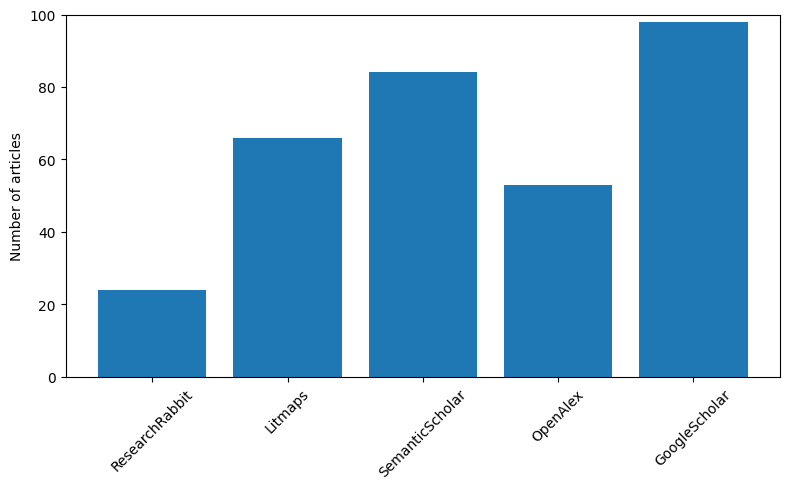

In [10]:

df = pd.DataFrame([
    {'Paper': 'Paper', 'ferramenta': 'ResearchRabbit', 'quantidade': 24},
    {'Paper': 'Paper', 'ferramenta': 'Litmaps', 'quantidade': 66},
    {'Paper': 'Paper', 'ferramenta': 'SemanticScholar', 'quantidade': 84},
    {'Paper': 'Paper', 'ferramenta': 'OpenAlex', 'quantidade': 53},
    {'Paper': 'Paper', 'ferramenta': 'GoogleScholar', 'quantidade': 98}

])

ferramentas = df['ferramenta']
valores = df['quantidade']

plt.figure(figsize=(8, 5))
plt.bar(ferramentas, valores)

plt.ylabel('Number of articles')
plt.xticks(rotation=45)
plt.ylim(0, max(valores) + 2)

plt.tight_layout()
plt.show()

